In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.metrics import accuracy_score  
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve, auc, roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

# Explore Data

In [2]:
df = pd.read_csv('train.csv')

### Remove 'Ticket', 'PassengerId','Cabin'

In [3]:
df.drop(['PassengerId','Ticket'], axis=1, inplace=True)

### Convert Names & Cabin to theri character length

In [4]:
df['Name'] = df['Name'].str.len()
df['Cabin'] = df['Cabin'].str.len()

### Pclass vs Survived

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

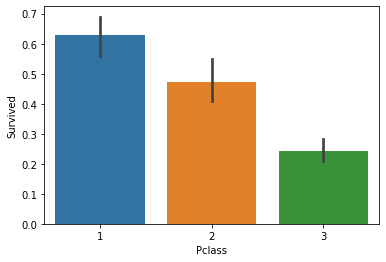

In [5]:
sns.barplot(x='Pclass', y='Survived', data=df)

### Embarked vs Survived

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

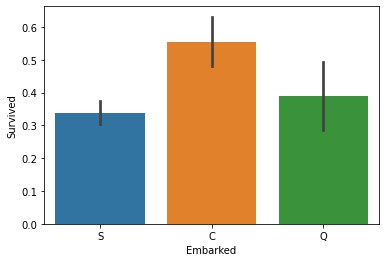

In [6]:
sns.barplot(x='Embarked', y='Survived', data=df)

### Check Correlations

<AxesSubplot:>

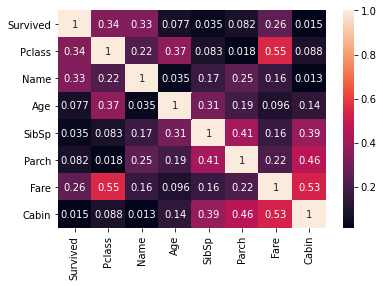

In [7]:
sns.heatmap(df.corr().abs(),annot=True)

### Check missing cells

<AxesSubplot:>

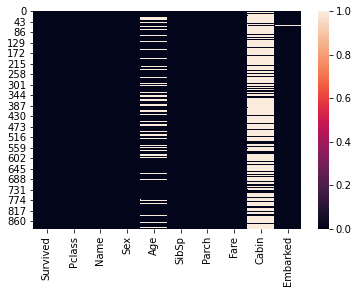

In [8]:
sns.heatmap(df.isna())

### Select target and features

In [9]:
X = df.iloc[:,1:]
y = df['Survived']

### Split data to train and test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state= 42)

In [11]:
X_train.shape, X_test.shape

((534, 9), (357, 9))

### Categorizing numeric and categorical features

In [12]:
numeric_features = ['Name', 'Fare','Age','Cabin']
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"), 
    RobustScaler()
    )

In [13]:
categorical_features = ['Embarked', 'Sex','Pclass']
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"), 
    OneHotEncoder(handle_unknown="ignore")
    )

### Pre-Process transformations

In [14]:
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat',categorical_transformer, categorical_features),
                  ('do_nothing', 'passthrough',['Parch','SibSp'])])

# A. Model creation with 'LogisticRegression'

In [15]:
pipeline_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=100))

### Fit the train data with 'LogisticRegression'

In [16]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Name', 'Fare', 'Age',
                                                   'Cabin']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='

### Calculate a cross-validation score with 5 folds

In [17]:
from sklearn.model_selection import cross_validate

cv_lr = cross_validate(pipeline_lr, X_train, y_train,
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv_lr = pd.DataFrame(cv_lr)
print(cv_lr)

   fit_time  score_time  test_score  train_score
0  0.048871    0.011053    0.859813     0.803279
1  0.021655    0.007112    0.822430     0.807963
2  0.021934    0.007168    0.728972     0.831382
3  0.021527    0.006873    0.766355     0.840749
4  0.021207    0.007188    0.849057     0.796729


In [18]:
cv_lr.mean()

fit_time       0.027039
score_time     0.007879
test_score     0.805325
train_score    0.816020
dtype: float64

### Calculate the train and test accuracy

In [19]:
print('train acc', round(pipeline_lr.score(X_train, y_train), 3))
print('test acc ', round(pipeline_lr.score(X_test, y_test), 3))

train acc 0.813
test acc  0.79


### Calculate precision and recall

In [20]:
ypred_lr = pipeline_lr.predict(X_test)

In [21]:
accuracy_score(y_test,ypred_lr) 

0.7899159663865546

In [22]:
precision = precision_score(y_test,ypred_lr)
recall = recall_score(y_test,ypred_lr)

print('precision:', precision_score(y_test,ypred_lr), '     recall:',round(recall_score(y_test,ypred_lr),4))

precision: 0.775      recall: 0.6596


### Confusion Matrix

In [23]:
conf_mat_lr = confusion_matrix(y_test,ypred_lr)
conf_mat_lr

array([[189,  27],
       [ 48,  93]])

<AxesSubplot:title={'center':'Confusion Matrix'}>

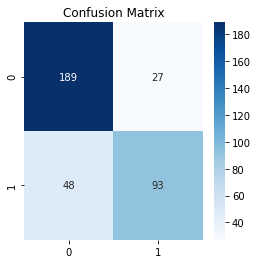

In [24]:
#plot the heatmap
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

sns.heatmap(conf_mat_lr, annot=True, ax = ax, fmt='g', cmap = 'Blues')

### Receiver Operator Curve and Area Under the Curve

In [25]:
probs_lr = pipeline_lr.predict_proba(X_test) 
fpr, tpr, threshold = roc_curve(y_test, probs_lr[:,1])

Area under the curve =  0.8458760178618335


(0.0, 1.0)

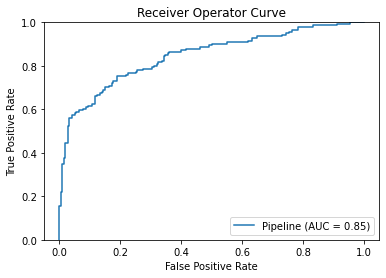

In [26]:
# Calculating area under the curve
auc_score = auc(fpr, tpr)
print("Area under the curve = ",auc_score)

plot_roc_curve(pipeline_lr, X_test, y_test)  
plt.title("Receiver Operator Curve")

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.ylim([0,1.00])

### Precision Recall Curve

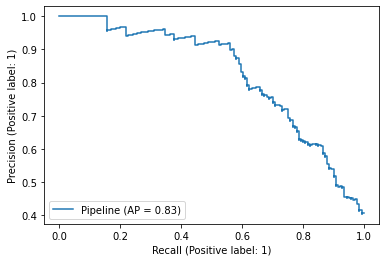

In [27]:
plot_precision_recall_curve(pipeline_lr, X_test, y_test)

In [28]:
precisions, recalls, thresholds = precision_recall_curve(y_test, probs_lr[:,1])

### Area under precision recall curve 

In [29]:
pr_area = auc(recalls, precisions)
pr_area

0.8243833351028006

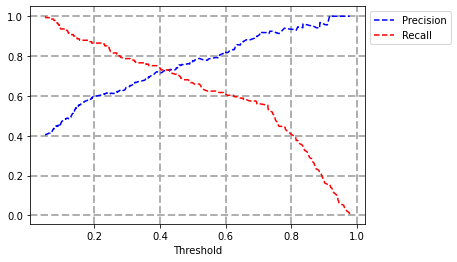

In [30]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(linestyle='--', linewidth=2)
plt.show()

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------

# B. Train with Random Forest classification model

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier

In [32]:
pipeline_rf = make_pipeline(preprocessor, RandomForestClassifier(max_depth= 5))

### Fit the train data with 'Random Forest'

In [33]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['Name', 'Fare', 'Age',
                                                   'Cabin']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='

In [34]:
print('train acc', round(pipeline_rf.score(X_train, y_train), 3))
print('test acc ', round(pipeline_rf.score(X_test, y_test), 3))

train acc 0.878
test acc  0.801


### Calculate a cross-validation score with 5 folds

In [35]:
from sklearn.model_selection import cross_validate

cv_rf = cross_validate(pipeline_rf, X_train, y_train,
                    cv=5,
                    scoring='accuracy',
                    return_train_score=True
)
# convert the dictionary of lists into a DataFrame
cv_rf = pd.DataFrame(cv_rf)
print(cv_rf)

   fit_time  score_time  test_score  train_score
0  0.166497    0.016813    0.859813     0.882904
1  0.140853    0.016650    0.822430     0.889930
2  0.140227    0.016698    0.757009     0.868852
3  0.139502    0.016601    0.757009     0.887588
4  0.140404    0.016526    0.877358     0.862150


In [36]:
cv_rf.mean()

fit_time       0.145497
score_time     0.016657
test_score     0.814724
train_score    0.878285
dtype: float64

### Calculate the train and test accuracy

In [37]:
print('train acc', round(pipeline_rf.score(X_train, y_train), 3))
print('test acc ', round(pipeline_rf.score(X_test, y_test), 3))

train acc 0.878
test acc  0.801


### Calculate precision and recall

In [38]:
ypred_rf = pipeline_rf.predict(X_test)

In [39]:
accuracy_score(y_test,ypred_rf) 

0.8011204481792717

In [40]:
precision = precision_score(y_test,ypred_rf)
recall = recall_score(y_test,ypred_rf)

print('precision:', precision_score(y_test,ypred_rf), '     recall:',round(recall_score(y_test,ypred_rf),4))

precision: 0.8125      recall: 0.6454


### Confusion Matrix

In [41]:
conf_mat_rf = confusion_matrix(y_test,ypred_rf)
conf_mat_rf

array([[195,  21],
       [ 50,  91]])

<AxesSubplot:title={'center':'Confusion Matrix'}>

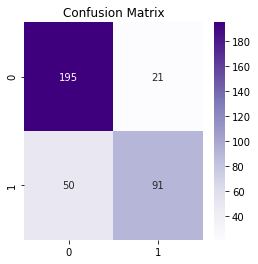

In [42]:
#plot the heatmap
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

sns.heatmap(conf_mat_rf, annot=True, ax = ax, fmt='g', cmap = 'Purples')

### Receiver Operator Curve and Area Under the Curve

In [43]:
probs_rf = pipeline_rf.predict_proba(X_test) 
fpr, tpr, threshold = roc_curve(y_test, probs_rf[:,1])

Area under the curve =  0.8611275282374572


(0.0, 1.0)

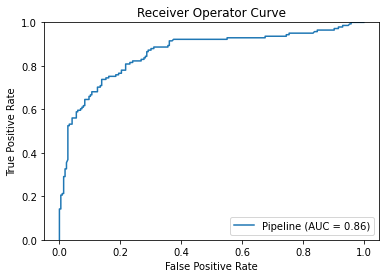

In [44]:
# Calculating area under the curve
auc_score = auc(fpr, tpr)
print("Area under the curve = ",auc_score)

plot_roc_curve(pipeline_rf, X_test, y_test)  
plt.title("Receiver Operator Curve")

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.ylim([0,1.00])

### Precision Recall Curve

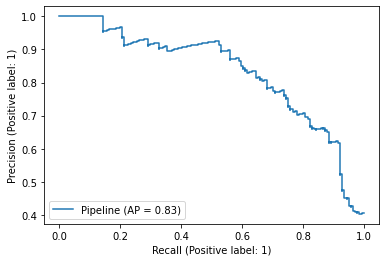

In [45]:
plot_precision_recall_curve(pipeline_rf, X_test, y_test)

In [46]:
precisions, recalls, thresholds = precision_recall_curve(y_test, probs_rf[:,1])

### Area under precision recall curve 

In [47]:
pr_area = auc(recalls, precisions)
pr_area

0.830942495113665

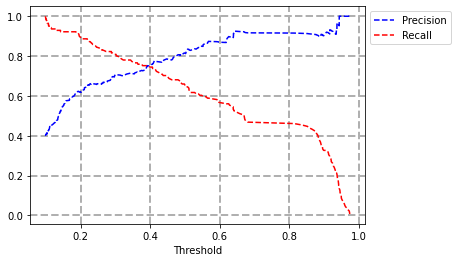

In [48]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "r--", label="Recall")
plt.xlabel("Threshold")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(linestyle='--', linewidth=2)
plt.show()

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------

### Compare accuracy between 'Random Forest' & 'LogisticRegression' on test data

In [49]:
logistic_regression_test_accu = round(pipeline_lr.score(X_test, y_test), 3)
random_forest_train_accu = round(pipeline_rf.score(X_test, y_test), 3)

Serie = {'LogisticRegression_test': logistic_regression_test_accu,'RandomForest_test':random_forest_train_accu}
pd.Series(Serie, index=['LogisticRegression_test', 'RandomForest_test'])

LogisticRegression_test    0.790
RandomForest_test          0.801
dtype: float64

<AxesSubplot:title={'center':'Confusion Matrix-rf'}>

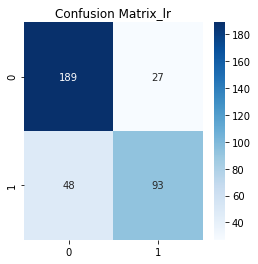

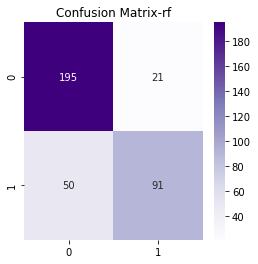

In [57]:
#plot the heatmap
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.set_xlabel('Predicted labels_lr')
ax.set_ylabel('True labels_lr')
ax.set_title('Confusion Matrix_lr')
sns.heatmap(conf_mat_lr, annot=True, ax = ax, fmt='g', cmap = 'Blues')

#plot the heatmap
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot()
ax.set_xlabel('Predicted labels_rf')
ax.set_ylabel('True labels_rf')
ax.set_title('Confusion Matrix-rf')
sns.heatmap(conf_mat_rf, annot=True, ax = ax, fmt='g', cmap = 'Purples')

------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------

### Predict on new test data with 'Random Forest' & 'LogisticRegression'

In [58]:
df_test = pd.read_csv('test.csv')

In [59]:
df_test.drop(['Ticket'], axis=1, inplace=True)
df_test['Name'] = df_test['Name'].str.len()
df_test['Cabin'] = df_test['Cabin'].str.len()
pred_log_reg_lr=df_test[['PassengerId']]
pred_log_reg_rf=df_test[['PassengerId']]
del df_test['PassengerId']

In [60]:
test_pred_lr = pipeline_lr.predict(df_test)

In [61]:
test_pred_rf = pipeline_rf.predict(df_test)

In [62]:
pred_log_reg_lr['Survived']=test_pred_lr

<ipython-input-62-12cc404ff01c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_log_reg_lr['Survived']=test_pred_lr


In [63]:
pred_log_reg_rf['Survived']=test_pred_rf

<ipython-input-63-d40e7ad9b60d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_log_reg_rf['Survived']=test_pred_rf


In [64]:
pred_log_reg_lr.to_csv('Survived_lr.csv', index=False)

In [65]:
pred_log_reg_rf.to_csv('Survived_rf.csv', index=False)